<h1><center>US AIRLINE SENTIMENT ANALYSIS USING FINE-TUNED BERT MODEL</center></h1>

<center>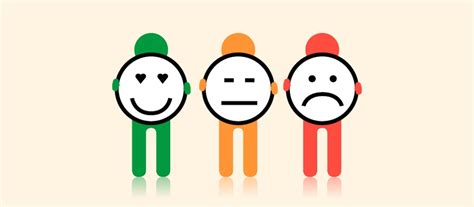</center>





## **Introduction**
In this notebook, I'll be exploring BERT model from Hugging Face to perform sentiment analysis on airline tweets. 

BERT is a transformers model pretrained on a large corpus of English data in a self-supervised fashion. This means it was pretrained on the raw texts only, with no humans labelling them in any way (which is why it can use lots of publicly available data) with an automatic process to generate inputs and labels from those texts. BERT was pretrained with two main objectives namely MLP (Masked Language Prediction) and NSP (Next Sentence Prediction).

Here, I'll be training a classifier (fully-connected network) with the features produced by the BERT as inputs to categorize tweets into **Positive**, **Negative** and **Neutral**.

## **Let's get started**

Let's begin with some initial setup before we dive into data exploration, we will need,

1.   [Transformers library](https://huggingface.co/docs/transformers/index) from Hugging Face 
2.   Kaggle to use their public API to download datasets









In [1]:
!pip install kaggle
!pip install transformers

     |████████████████████████████████| 3.5 MB 3.7 MB/s 
     |████████████████████████████████| 6.8 MB 36.2 MB/s 
     |████████████████████████████████| 67 kB 3.8 MB/s 
     |████████████████████████████████| 596 kB 41.2 MB/s 
     |████████████████████████████████| 895 kB 11.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
# Import libraries

import random
from collections import defaultdict
import matplotlib.pyplot as plt
from textwrap import wrap
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import os

from matplotlib import rc
from pylab import rcParams
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import (
    AdamW,
    BertModel,
    BertTokenizer,
    get_linear_schedule_with_warmup,
)

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
# Set color palette for plots
color = lambda: random.randint(0, 255)
colors = ['#%02X%02X%02X' %(color(), color(), color()) for i in range(6)]
sns.set_palette(sns.color_palette(colors))
rcParams['figure.figsize'] = 12, 10

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Check if cuda is enabled in the device
device = torch.cuda.is_available()

if not device:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## **Data Exploration**

Here, we use US airline twitter dataset from [kaggle](https://www.kaggle.com/crowdflower/twitter-airline-sentiment). Set your credentials as env below to authenticate the API's to download dataset.

In [5]:
os.environ['KAGGLE_USERNAME'] = 'xxxxxxxxxxxxxxx'
os.environ['KAGGLE_KEY'] = 'xxxxxxxxxxxxxxxxxxxx'

In [6]:
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile

os.makedirs('data', exist_ok=True)

api = KaggleApi()
api.authenticate()
api.dataset_download_file('crowdflower/twitter-airline-sentiment', 'Tweets.csv')
zip_file = ZipFile('Tweets.csv.zip')
zip_file.extractall('data')
zip_file.close()
os.remove('Tweets.csv.zip')


In [7]:
df = pd.read_csv('data/Tweets.csv')

In [8]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Let's check the data distribution among the three classes.

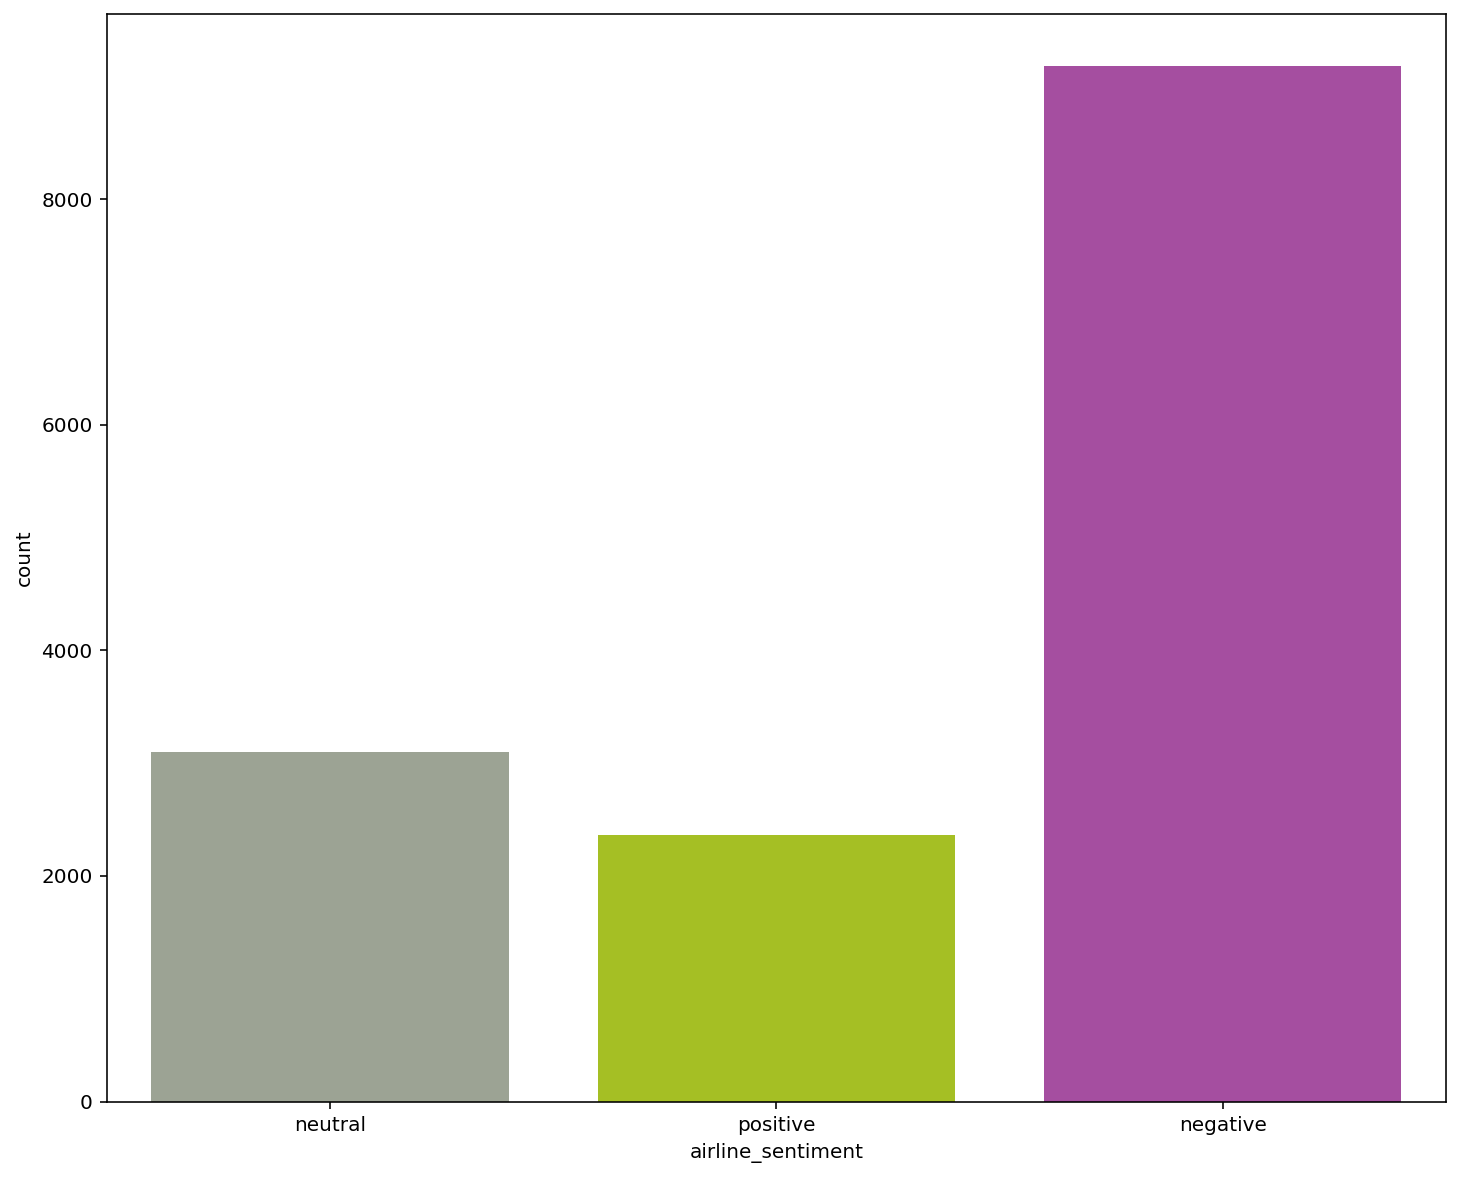

In [9]:
sns.countplot(x=df.airline_sentiment)

What do you notice looking at the data? 

As is it can seen that, the dataset is hugely imbalanced. It has more negative tweets in comparison to neutral and positive tweets. But it's okay, we will not be diving into oversampling or undersampling techniques to deal with class imbalance. Though the negative tweets are more, we still have some positive and neutral tweets.

## **Data Preprocessing**

Let's do some slight pre-processing on the dataset before we train them on the model. There might be some emoticons, mentions, hashtags which should be taken as a single entity. Remove URLs, numbers as they don't convey any useful information. Furthermore, in case of lengthening of words which are more common in tweets are to be normalized. We will not be converting it into tokens as it will be carried out by BERT. 

In [10]:
import re
def pre_processing(df):
    df['text'] = df['text'].apply(lambda x: re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', x))
    df['text'] = df['text'].apply(lambda x: re.sub('(@[A-Za-z0-9_]+)','', x))

In [11]:
# Light cleanup before tokenization
pre_processing(df)

# Encode labels
possible_labels = df.airline_sentiment.unique()
labels_map = {possible_labels[idx]: idx for idx, label in enumerate(possible_labels)}
df['labels'] = df.airline_sentiment.replace(labels_map)

So we have the tweets and label, what's next? 

Before jumping into classification task, there is a need to encode the texts into appropriate form such that BERT can use it as input. Here's where BERT's tokenizer comes to play, we will be using `encode_plus` which does the following:

1.   Tokenize the input sentence
2.   Add the [CLS] and [SEP] tokens
3.   Pad or truncate the sentence to the maximum length allowed
4.   Encode the tokens into their corresponding IDs Pad or truncate all         sentences to the same length
5.   Create the attention masks which explicitly differentiate real tokens from [PAD] tokens  







In [12]:
MODEL = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL, do_lower_case=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Let's view the length of the frequently used tokens to get an idea about the token length. Based on the plot below, we are safe to set 64 as the token length.

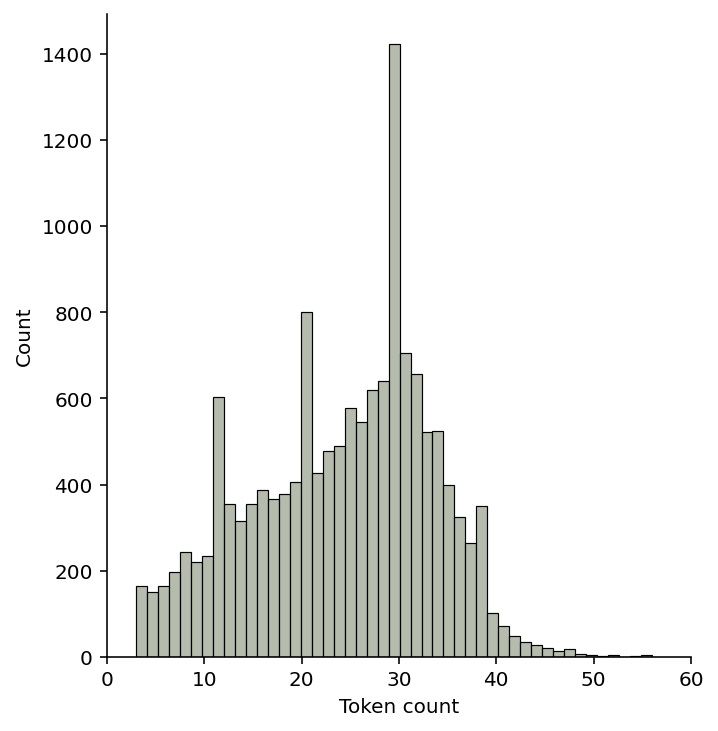

In [13]:
tokens = [len(tokenizer.encode(text, max_length=512, truncation=True)) for text in df.text]
sns.displot(tokens)
plt.xlim([0, 60]);
plt.xlabel('Token count');

A simple code to build custom Dataset and load the data using a DataLoader.

In [14]:
from torch.utils.data import Dataset, DataLoader

# Define a custom dataset, more info on how to build custom dataset can be 
# found at https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class CustomDataset(Dataset):
    
    def __init__(
        self, 
        tweets, 
        labels, 
        tokenizer, 
        max_length
    ):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.tweets)
    
    def __getitem__(self, idx):
        tweet = self.tweets[idx]
        label = self.labels[idx]
        
        tokenize = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'tweet': tweet,
            'input_ids': tokenize['input_ids'].flatten(),
            'attention_mask': tokenize['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long)
               }

In [15]:
MAX_LENGTH = 64
TEST_SIZE = 0.1
VALID_SIZE = 0.5
BATCH_SIZE = 16
NUM_WORKERS = 2

train_sampler, test_sampler = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE)
valid_sampler, test_sampler = train_test_split(test_sampler, test_size=VALID_SIZE, random_state=RANDOM_STATE)

train_set = CustomDataset(
    train_sampler['text'].to_numpy(),
    train_sampler['labels'].to_numpy(),
    tokenizer, 
    MAX_LENGTH
)
test_set = CustomDataset(
    test_sampler['text'].to_numpy(),
    test_sampler['labels'].to_numpy(),
    tokenizer, 
    MAX_LENGTH
)
valid_set = CustomDataset(
    valid_sampler['text'].to_numpy(), 
    valid_sampler['labels'].to_numpy(), 
    tokenizer, 
    MAX_LENGTH
)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

Most of the heavy lifting work is carried out by BERT. However, we modify the last layer in accordance to our classification task.

In [16]:
from torch import nn
class AirlineSentimentClassifier(nn.Module):
    
    def __init__(self, num_labels):
        super (AirlineSentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL)
        self.dropout = nn.Dropout(p=0.2)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        out = self.classifier(pooled_output)
        return out
        

In [17]:
model = AirlineSentimentClassifier(len(labels_map))
print(model)

# Move tensors to GPU on CUDA enables devices
if device:
    model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AirlineSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

## **Loss Funtion and Optimizer**

Let's define a loss function and optimizer. We will be using Categorial Cross-Entropy loss and [AdamW](https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#transformers.AdamW) optimizer (since it implements weight decay fix to coventional Adam algorithm) by Hugging Face. 

In [18]:
n_epochs = 10
learning_rate =2e-5

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, correct_bias=False)

# Define scheduler
training_steps = len(train_loader)*n_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0,
    num_training_steps=training_steps
)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


## **Training**

Let's begin training our model, the recommended hyperparameters for BERT fine tuning can be found in this [paper](https://arxiv.org/abs/1810.04805). Here we will start with 10 epochs to see how well it performs.  

In [19]:
# Track changes in validation loss
valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):
    
    # Setting training and validation loss
    train_loss = []
    validation_loss = []
    tr_predictions = 0
    acc = 0
    val_predictions = 0
    
    ####################
    #  Train the model #
    ####################
    model = model.train()
    for data in train_loader:
        
        # Moving tensors to GPU on CUDA enabled devices
        if device:
            input_ids, attention_mask, targets = data["input_ids"].cuda(), data["attention_mask"].cuda(), data["targets"].cuda()
        # Clear the gradients of variables 
        optimizer.zero_grad()
        
        #### Forward pass
        # Pass input through the model
        output = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # Compute batch loss
        loss = criterion(output, targets)
        # Convert output probabilities to class probabilities
        _, pred = torch.max(output, 1)
        # Track correct predictions
        tr_predictions += torch.sum(pred == targets)
        
        #### Backward Pass
        # Compute gradients wrt to model parameters
        loss.backward()
        # To avoid exploding gradients, we clip the gradients of the model
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # Perform parameter update
        optimizer.step()
        # Update learning rate
        scheduler.step()        
        # Update loss per mini batches
        train_loss.append(loss.item())
        
    ######################
    # Validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for data in valid_loader:

            # Moving tensors to GPU on CUDA enabled devices
            if device:
                input_ids, attention_mask, targets = data["input_ids"].cuda(), data["attention_mask"].cuda(), data["targets"].cuda() 

            #### Forward pass
            # Pass input through the model
            output = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            # Compute batch loss
            loss = criterion(output, targets)  
            # Convert output probabilities to class probabilities
            _, pred = torch.max(output, 1) 
            # Update loss per mini batches
            validation_loss.append(loss.item())
            # Track correct predictions
            val_predictions += torch.sum(pred == targets)
    
    # Compute accuracy
    train_accuracy = tr_predictions.double()/len(train_sampler)
    val_accuracy = val_predictions.double()/len(valid_sampler)
    
    # Print loss statistics
    print('Epoch: {}/{} \n\tTraining Loss: {:.6f} \n\tValidation Loss: {:.6f} \n\tTrain Accuracy: {:.6f} \n\tVal Accuracy: {:.6f}'.format(epoch,n_epochs, np.mean(train_loss), np.mean(validation_loss), train_accuracy, val_accuracy))
    
    # Save model if validation loss is decreased
    if val_accuracy > acc:
        print('Saving model...')
        torch.save(model.state_dict(), 'bert_base_fine_tuned.pt')
        acc = val_accuracy

Epoch: 1/10 
	Training Loss: 0.478485 
	Validation Loss: 0.426510 
	Train Accuracy: 0.813221 
	Val Accuracy: 0.848361
Saving model...
Epoch: 2/10 
	Training Loss: 0.251598 
	Validation Loss: 0.587404 
	Train Accuracy: 0.912720 
	Val Accuracy: 0.837432
Saving model...
Epoch: 3/10 
	Training Loss: 0.147462 
	Validation Loss: 0.694001 
	Train Accuracy: 0.958333 
	Val Accuracy: 0.848361
Saving model...
Epoch: 4/10 
	Training Loss: 0.095958 
	Validation Loss: 0.852052 
	Train Accuracy: 0.976548 
	Val Accuracy: 0.841530
Saving model...
Epoch: 5/10 
	Training Loss: 0.062927 
	Validation Loss: 0.967488 
	Train Accuracy: 0.985504 
	Val Accuracy: 0.842896
Saving model...
Epoch: 6/10 
	Training Loss: 0.042360 
	Validation Loss: 1.066000 
	Train Accuracy: 0.990437 
	Val Accuracy: 0.840164
Saving model...
Epoch: 7/10 
	Training Loss: 0.032142 
	Validation Loss: 1.132496 
	Train Accuracy: 0.992410 
	Val Accuracy: 0.833333
Saving model...
Epoch: 8/10 
	Training Loss: 0.024429 
	Validation Loss: 1.184

We will not train the model beyond this, as it is seen that the validation loss seems to slightly increase and the validation accuracy is more or less close to 83%.

## **Test the fine-tuned network**

Although the training accuracy reached over 99%, let's define some metrics and see how the model performs on unseen data.

In [22]:
# Track test loss
test_loss = 0.0
class_predictions = list(0. for i in range(3))
class_total = list(0. for i in range(3))
predictions = []
labels = []

model.eval()
with torch.no_grad():
    for data in test_loader:

        # Moving tensors to GPU on CUDA enabled devices
        if device:
            input_ids, attention_mask, targets = data["input_ids"].cuda(), data["attention_mask"].cuda(), data["targets"].cuda() 

        #### Forward pass
        # Pass input through the model
        output = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # Compute batch loss
        loss = criterion(output, targets)   
        # Update loss
        test_loss += loss.item()
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)  

        predictions.extend(pred)
        labels.extend(targets)
    
predictions = torch.stack(predictions) if not device else torch.stack(predictions).cpu()
labels = torch.stack(labels) if not device else torch.stack(labels).cpu()





In [23]:
print(classification_report(predictions, labels, target_names=['neutral', 'positive','negative']))

              precision    recall  f1-score   support

     neutral       0.68      0.71      0.69       146
    positive       0.79      0.81      0.80       118
    negative       0.92      0.90      0.91       468

    accuracy                           0.85       732
   macro avg       0.79      0.81      0.80       732
weighted avg       0.85      0.85      0.85       732



## **Visualizations**
Let's visualize our model performance through plotting a confusion matrix. Metrics for positive tweets and neutral tweets are similar. It is also seen that, the model performs well in the case of negative tweets. We can conclude that it does an average job, also we cannot go entirely by accuracy when it comes to class imbalance. 

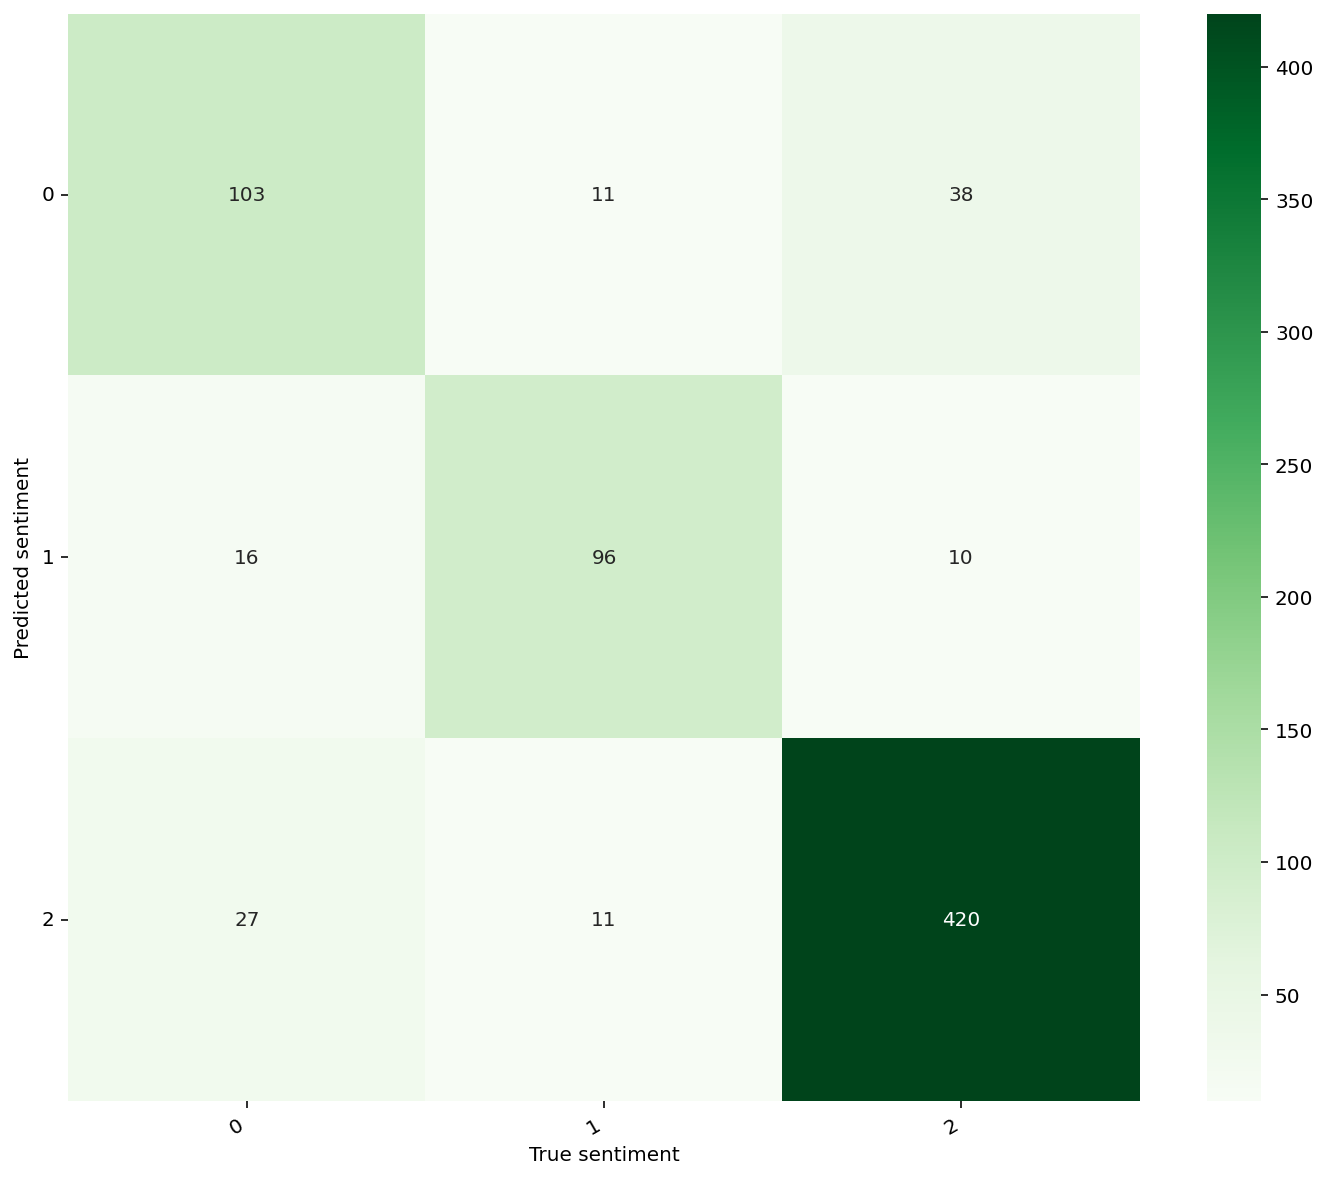

In [24]:
cm = confusion_matrix(labels, predictions)
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.xlabel('True sentiment')
plt.ylabel('Predicted sentiment');